<a href="https://colab.research.google.com/github/taro-univ/PRML_Mounting/blob/main/Section7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

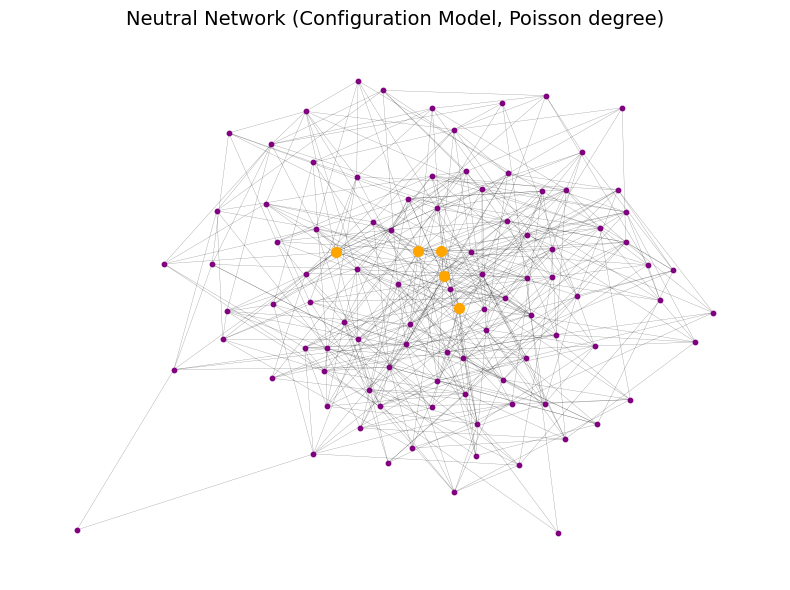

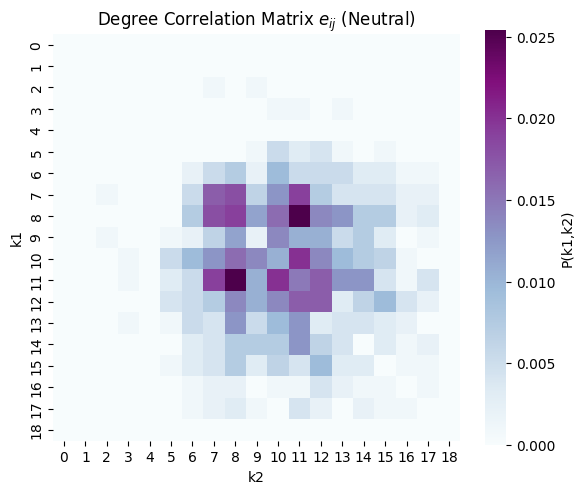

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# 1. パラメータ設定
N = 100
k_avg = 10
seed = 42
np.random.seed(seed)

# 2. ポアソン分布に従う次数列を生成
degree_sequence = np.random.poisson(k_avg, N)
# 和が奇数だと実現できないので調整
if sum(degree_sequence) % 2 == 1:
    degree_sequence[0] += 1

# 3. Configuration Modelでネットワーク生成
G = nx.configuration_model(degree_sequence, seed=seed)
G = nx.Graph(G)  # 自己ループと多重辺を削除
G.remove_edges_from(nx.selfloop_edges(G))

# 4. ネットワーク描画（最大連結成分）
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_sub, seed=seed)
degrees = dict(G_sub.degree())
nx.draw_networkx_nodes(G_sub, pos, node_size=10, node_color="purple")
# 上位5ノード（ハブ）を強調
top5 = sorted(degrees, key=lambda x: degrees[x], reverse=True)[:5]
nx.draw_networkx_nodes(G_sub, pos, nodelist=top5, node_size=50, node_color="orange")
nx.draw_networkx_edges(G_sub, pos, width=0.2, alpha=0.5)
plt.title("Neutral Network (Configuration Model, Poisson degree)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# 5. 次数相関行列 e_ij の可視化
from collections import Counter
from itertools import combinations

max_k = max(degree_sequence)
eij = np.zeros((max_k+1, max_k+1))

# 各エッジの次数をカウントして行列を構成
for u, v in G.edges():
    k1 = G.degree[u]
    k2 = G.degree[v]
    eij[k1, k2] += 1
    eij[k2, k1] += 1  # 対称性

eij /= eij.sum()  # 正規化

# 可視化
plt.figure(figsize=(6, 5))
sns.heatmap(eij[:25, :25], cmap="BuPu", square=True, cbar_kws={'label': 'P(k1,k2)'})
plt.xlabel("k2")
plt.ylabel("k1")
plt.title("Degree Correlation Matrix $e_{ij}$ (Neutral)")
plt.tight_layout()
plt.show()


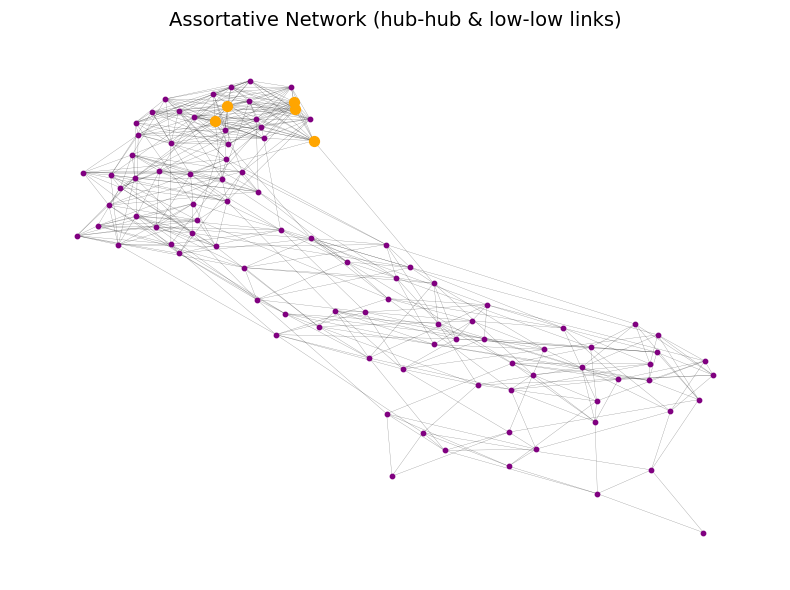

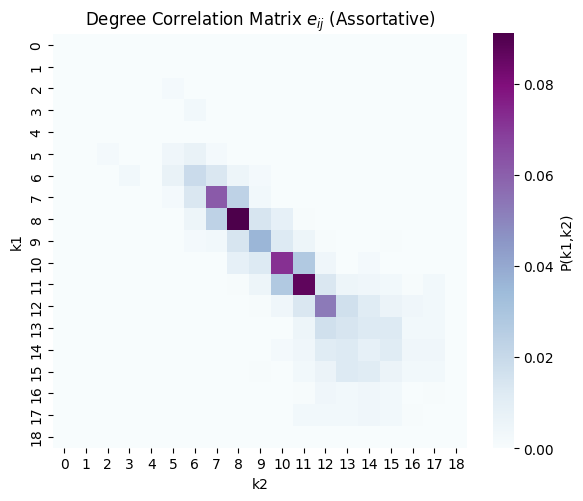

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- パラメータ設定 ---
N = 100
k_avg = 10
np.random.seed(42)
random.seed(42)

# --- ポアソン次数列生成 ---
degree_sequence = np.random.poisson(k_avg, N)
if sum(degree_sequence) % 2 == 1:
    degree_sequence[0] += 1

# --- 初期ネットワーク（Configuration Model） ---
G = nx.configuration_model(degree_sequence)
G = nx.Graph(G)  # 多重辺と自己ループ除去
G.remove_edges_from(nx.selfloop_edges(G))

# --- リワイヤリングで相関性を強める ---
def assortative_rewire(G, iterations=10000):
    edges = list(G.edges())
    for _ in range(iterations):
        u, v = random.choice(edges)
        x, y = random.choice(edges)
        if len(set([u, v, x, y])) < 4:
            continue
        deg = G.degree
        d0 = abs(deg[u] - deg[v]) + abs(deg[x] - deg[y])
        d1 = abs(deg[u] - deg[x]) + abs(deg[v] - deg[y])
        if not G.has_edge(u, x) and not G.has_edge(v, y):
            if d1 < d0:  # 相関的な rewiring：次数差を小さく
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, x)
                G.add_edge(v, y)
                edges = list(G.edges())
    return G

G = assortative_rewire(G)

# --- 最大連結成分抽出（描画用） ---
G_sub = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# --- ネットワーク描画 ---
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_sub, seed=42)
degrees = dict(G_sub.degree())
top5 = sorted(degrees, key=lambda x: degrees[x], reverse=True)[:5]

nx.draw_networkx_nodes(G_sub, pos, node_size=10, node_color="purple")
nx.draw_networkx_nodes(G_sub, pos, nodelist=top5, node_size=50, node_color="orange")
nx.draw_networkx_edges(G_sub, pos, width=0.2, alpha=0.5)
plt.title("Assortative Network (hub-hub & low-low links)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# --- e_ij（次数相関行列）を可視化 ---
max_k = max(degree_sequence)
eij = np.zeros((max_k+1, max_k+1))
for u, v in G.edges():
    k1 = G.degree[u]
    k2 = G.degree[v]
    eij[k1, k2] += 1
    eij[k2, k1] += 1
eij /= eij.sum()

plt.figure(figsize=(6, 5))
sns.heatmap(eij[:25, :25], cmap="BuPu", square=True, cbar_kws={'label': 'P(k1,k2)'})
plt.xlabel("k2")
plt.ylabel("k1")
plt.title("Degree Correlation Matrix $e_{ij}$ (Assortative)")
plt.tight_layout()
plt.show()


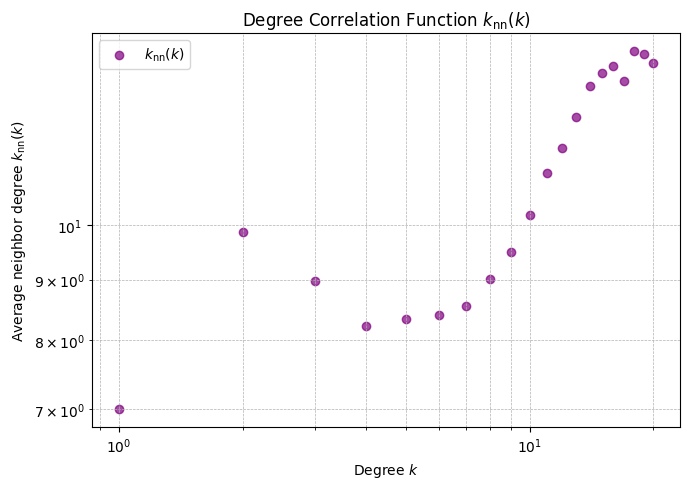

In [15]:
# --- k_nn(k) の計算 ---
k_nn_dict = {}  # k : [隣接ノード平均次数リスト]

for node in G.nodes():
    k = G.degree[node]
    neighbors = list(G.neighbors(node))
    if len(neighbors) == 0:
        continue
    neighbor_degrees = [G.degree[nb] for nb in neighbors]
    avg_neighbor_degree = np.mean(neighbor_degrees)
    k_nn_dict.setdefault(k, []).append(avg_neighbor_degree)

# --- 各 k に対して平均 ---
k_vals = sorted(k_nn_dict.keys())
knn_vals = [np.mean(k_nn_dict[k]) for k in k_vals]

# --- 可視化 ---
plt.figure(figsize=(7, 5))
plt.scatter(k_vals, knn_vals, color='purple', alpha=0.7, label=r'$k_{\mathrm{nn}}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree $k$")
plt.ylabel(r"Average neighbor degree $k_{\mathrm{nn}}(k)$")
plt.title("Degree Correlation Function $k_{\\mathrm{nn}}(k)$")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


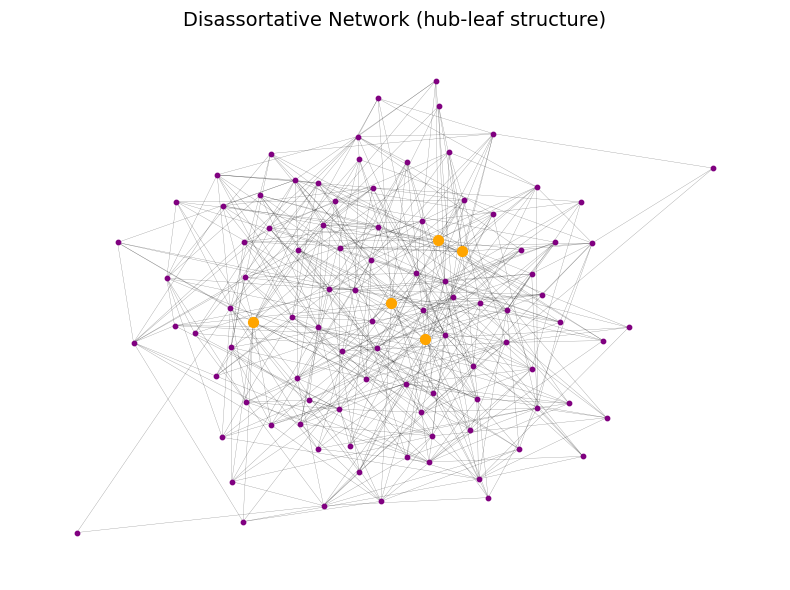

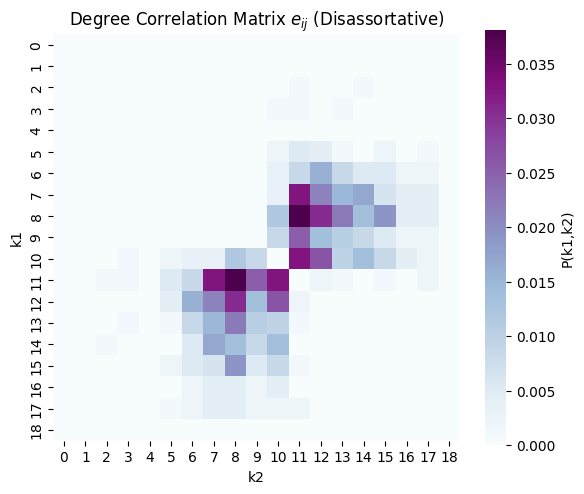

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- パラメータ設定 ---
N = 100
k_avg = 10
np.random.seed(42)
random.seed(42)

# --- ポアソン次数列 ---
degree_sequence = np.random.poisson(k_avg, N)
if sum(degree_sequence) % 2 == 1:
    degree_sequence[0] += 1

# --- 初期ネットワーク（Configuration Model） ---
G = nx.configuration_model(degree_sequence)
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

# --- 非相関的なリワイヤリング ---
def disassortative_rewire(G, iterations=10000):
    edges = list(G.edges())
    for _ in range(iterations):
        u, v = random.choice(edges)
        x, y = random.choice(edges)
        if len({u, v, x, y}) < 4:
            continue
        deg = G.degree
        d0 = abs(deg[u] - deg[v]) + abs(deg[x] - deg[y])
        d1 = abs(deg[u] - deg[x]) + abs(deg[v] - deg[y])
        if not G.has_edge(u, x) and not G.has_edge(v, y):
            if d1 > d0:  # 非相関：次数差がより大きくなる場合にスワップ
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, x)
                G.add_edge(v, y)
                edges = list(G.edges())
    return G

G = disassortative_rewire(G)

# --- 最大連結成分を抽出して描画 ---
G_sub = G.subgraph(max(nx.connected_components(G), key=len)).copy()

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_sub, seed=42)
degrees = dict(G_sub.degree())
top5 = sorted(degrees, key=lambda x: degrees[x], reverse=True)[:5]

nx.draw_networkx_nodes(G_sub, pos, node_size=10, node_color="purple")
nx.draw_networkx_nodes(G_sub, pos, nodelist=top5, node_size=50, node_color="orange")
nx.draw_networkx_edges(G_sub, pos, width=0.2, alpha=0.5)
plt.title("Disassortative Network (hub-leaf structure)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# --- 次数相関行列 e_ij の可視化 ---
max_k = max(degree_sequence)
eij = np.zeros((max_k+1, max_k+1))
for u, v in G.edges():
    k1 = G.degree[u]
    k2 = G.degree[v]
    eij[k1, k2] += 1
    eij[k2, k1] += 1
eij /= eij.sum()

plt.figure(figsize=(6, 5))
sns.heatmap(eij[:25, :25], cmap="BuPu", square=True, cbar_kws={'label': 'P(k1,k2)'})
plt.xlabel("k2")
plt.ylabel("k1")
plt.title("Degree Correlation Matrix $e_{ij}$ (Disassortative)")
plt.tight_layout()
plt.show()


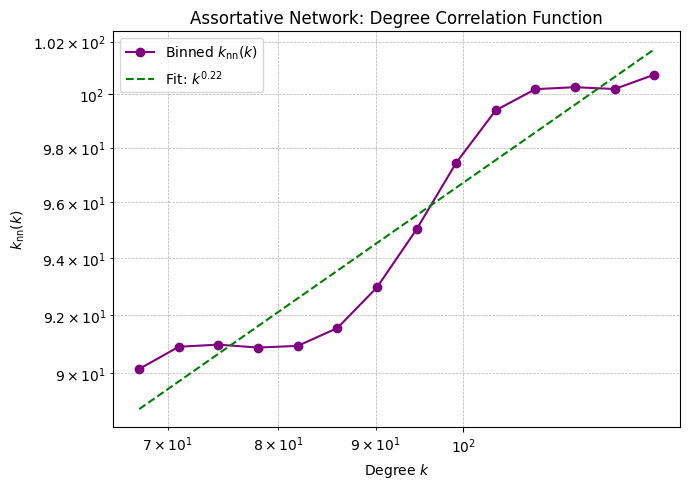

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import curve_fit

# --- パラメータ設定 ---
N = 1000
k_avg = 100
np.random.seed(42)
random.seed(42)

# --- ポアソン次数列 ---
degree_sequence = np.random.poisson(k_avg, N)
if sum(degree_sequence) % 2 == 1:
    degree_sequence[0] += 1

# --- 初期ネットワーク（Configuration Model） ---
G = nx.configuration_model(degree_sequence)
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

# --- 相関的リワイヤリング ---
def assortative_rewire(G, iterations=50000):
    edges = list(G.edges())
    for _ in range(iterations):
        u, v = random.choice(edges)
        x, y = random.choice(edges)
        if len({u, v, x, y}) < 4:
            continue
        deg = G.degree
        d0 = abs(deg[u] - deg[v]) + abs(deg[x] - deg[y])
        d1 = abs(deg[u] - deg[x]) + abs(deg[v] - deg[y])
        if not G.has_edge(u, x) and not G.has_edge(v, y):
            if d1 < d0:
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, x)
                G.add_edge(v, y)
                edges = list(G.edges())
    return G

G = assortative_rewire(G)

# --- k_nn(k) の計算 ---
k_nn_dict = {}
for node in G.nodes():
    k = G.degree[node]
    neighbors = list(G.neighbors(node))
    if len(neighbors) == 0:
        continue
    neighbor_degrees = [G.degree[nbr] for nbr in neighbors]
    avg = np.mean(neighbor_degrees)
    k_nn_dict.setdefault(k, []).append(avg)

k_vals = np.array(sorted(k_nn_dict.keys()))
knn_vals = np.array([np.mean(k_nn_dict[k]) for k in k_vals])

# --- ビンによるスムージング ---
bins = np.logspace(np.log10(k_vals.min()), np.log10(k_vals.max()), num=15)
digitized = np.digitize(k_vals, bins)
bin_means = [np.mean(knn_vals[digitized == i]) for i in range(1, len(bins))]
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

# --- スケーリングフィット ---
def power_law(x, a, mu):
    return a * x**mu

fit_mask = np.isfinite(bin_centers) & np.isfinite(bin_means)
popt, _ = curve_fit(power_law, np.array(bin_centers)[fit_mask], np.array(bin_means)[fit_mask])
a_fit, mu_fit = popt

# --- 可視化 ---
plt.figure(figsize=(7, 5))
plt.plot(bin_centers, bin_means, 'o-', color='purple', label=r'Binned $k_{\mathrm{nn}}(k)$')
plt.plot(bin_centers, power_law(np.array(bin_centers), *popt), 'g--',
         label=fr'Fit: $k^{{{mu_fit:.2f}}}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree $k$")
plt.ylabel(r"$k_{\mathrm{nn}}(k)$")
plt.title("Assortative Network: Degree Correlation Function")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


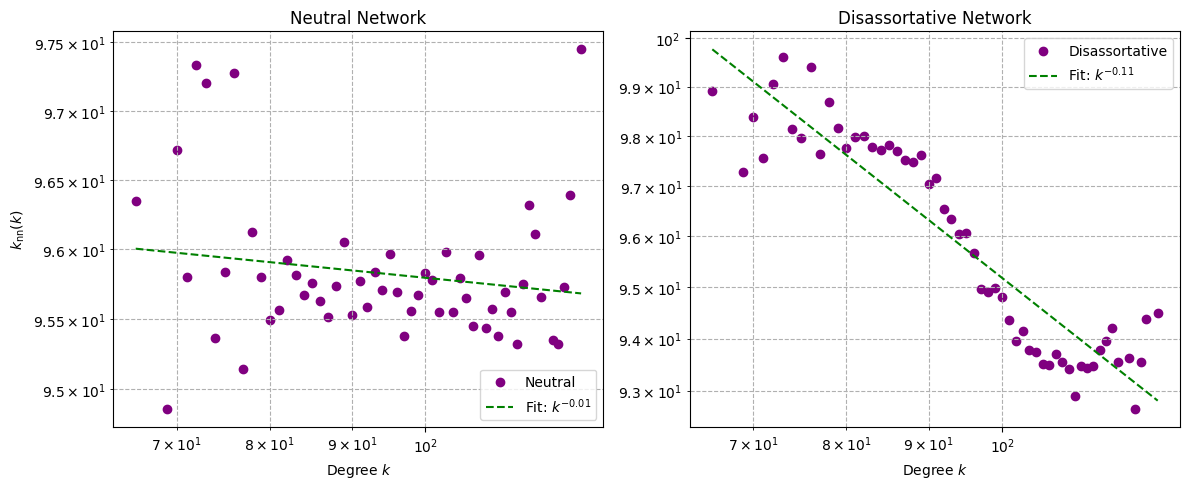

In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 共通設定 ---
N = 1000
k_avg = 100
np.random.seed(42)

# --- ポアソン次数列 ---
degree_sequence = np.random.poisson(k_avg, N)
if sum(degree_sequence) % 2 == 1:
    degree_sequence[0] += 1

# --- ネットワーク生成（Configuration Model） ---
G_neutral = nx.configuration_model(degree_sequence)
G_neutral = nx.Graph(G_neutral)
G_neutral.remove_edges_from(nx.selfloop_edges(G_neutral))

# --- 非相関的リワイヤリング ---
def disassortative_rewire(G, iterations=20000):
    edges = list(G.edges())
    for _ in range(iterations):
        u, v = random.choice(edges)
        x, y = random.choice(edges)
        if len({u, v, x, y}) < 4:
            continue
        deg = G.degree
        d0 = abs(deg[u] - deg[v]) + abs(deg[x] - deg[y])
        d1 = abs(deg[u] - deg[x]) + abs(deg[v] - deg[y])
        if not G.has_edge(u, x) and not G.has_edge(v, y):
            if d1 > d0:
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, x)
                G.add_edge(v, y)
                edges = list(G.edges())
    return G

import random
random.seed(42)
G_dis = disassortative_rewire(G_neutral.copy())

# --- k_nn(k) 計算関数 ---
def compute_knn(G):
    k_nn_dict = {}
    for node in G.nodes():
        k = G.degree[node]
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 0:
            continue
        neighbor_degrees = [G.degree[nbr] for nbr in neighbors]
        avg = np.mean(neighbor_degrees)
        k_nn_dict.setdefault(k, []).append(avg)

    k_vals = np.array(sorted(k_nn_dict.keys()))
    knn_vals = np.array([np.mean(k_nn_dict[k]) for k in k_vals])
    return k_vals, knn_vals

# --- フィット関数 ---
def power_law(x, a, mu):
    return a * x ** mu

# --- 中立ネットワークのプロット ---
k_neu, knn_neu = compute_knn(G_neutral)
popt_neu, _ = curve_fit(power_law, k_neu, knn_neu)

# --- 非相関ネットワークのプロット ---
k_dis, knn_dis = compute_knn(G_dis)
popt_dis, _ = curve_fit(power_law, k_dis, knn_dis)

# --- 描画 ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(k_neu, knn_neu, color='purple', label='Neutral')
axs[0].plot(k_neu, power_law(k_neu, *popt_neu), 'g--', label=fr'Fit: $k^{{{popt_neu[1]:.2f}}}$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_title("Neutral Network")
axs[0].set_xlabel("Degree $k$")
axs[0].set_ylabel(r"$k_{\mathrm{nn}}(k)$")
axs[0].legend()
axs[0].grid(True, which="both", ls="--")

axs[1].scatter(k_dis, knn_dis, color='purple', label='Disassortative')
axs[1].plot(k_dis, power_law(k_dis, *popt_dis), 'g--', label=fr'Fit: $k^{{{popt_dis[1]:.2f}}}$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title("Disassortative Network")
axs[1].set_xlabel("Degree $k$")
axs[1].legend()
axs[1].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


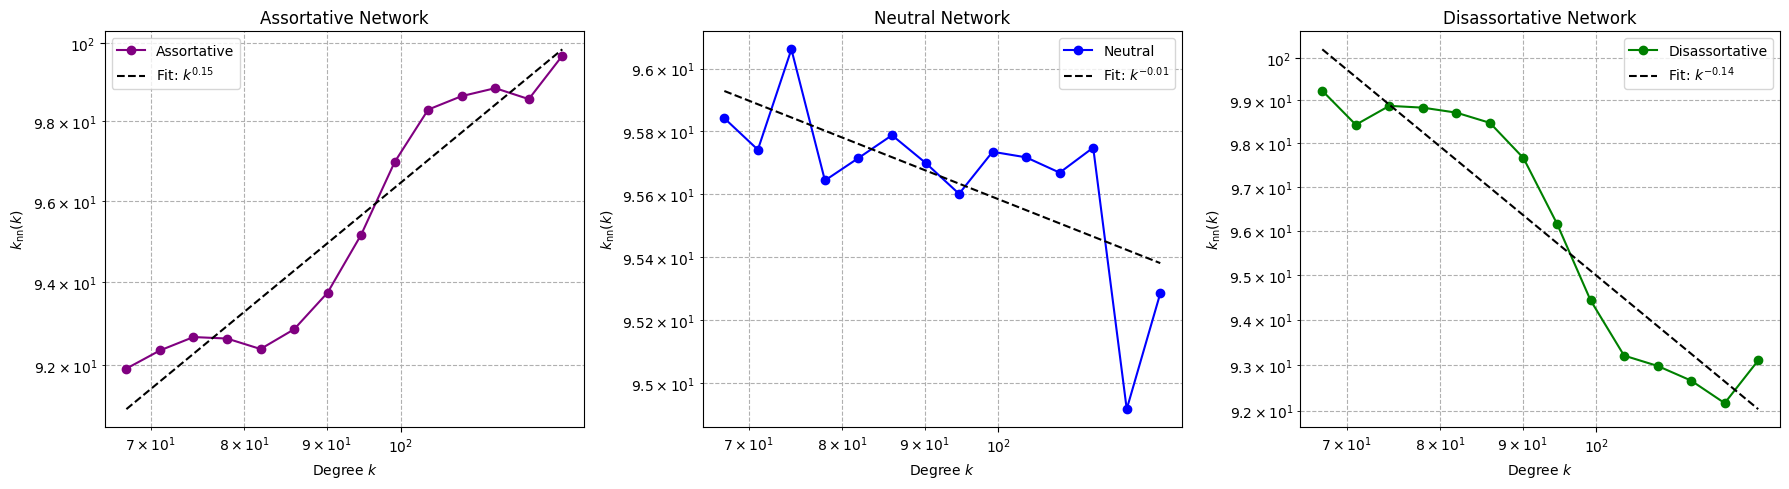

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.optimize import curve_fit
import random

# --- グローバル設定 ---
N = 1000
k_avg = 100
iterations = 30000
np.random.seed(42)
random.seed(42)

# --- 次数列生成 ---
degree_sequence = np.random.poisson(k_avg, N)
if sum(degree_sequence) % 2 == 1:
    degree_sequence[0] += 1

# --- Configuration Model ---
G_base = nx.configuration_model(degree_sequence)
G_base = nx.Graph(G_base)
G_base.remove_edges_from(nx.selfloop_edges(G_base))

# --- 相関リワイヤリング ---
def assortative_rewire(G, iterations):
    edges = list(G.edges())
    for _ in range(iterations):
        u, v = random.choice(edges)
        x, y = random.choice(edges)
        if len({u, v, x, y}) < 4:
            continue
        deg = G.degree
        d0 = abs(deg[u] - deg[v]) + abs(deg[x] - deg[y])
        d1 = abs(deg[u] - deg[x]) + abs(deg[v] - deg[y])
        if not G.has_edge(u, x) and not G.has_edge(v, y):
            if d1 < d0:
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, x)
                G.add_edge(v, y)
                edges = list(G.edges())
    return G

# --- 非相関リワイヤリング ---
def disassortative_rewire(G, iterations):
    edges = list(G.edges())
    for _ in range(iterations):
        u, v = random.choice(edges)
        x, y = random.choice(edges)
        if len({u, v, x, y}) < 4:
            continue
        deg = G.degree
        d0 = abs(deg[u] - deg[v]) + abs(deg[x] - deg[y])
        d1 = abs(deg[u] - deg[x]) + abs(deg[v] - deg[y])
        if not G.has_edge(u, x) and not G.has_edge(v, y):
            if d1 > d0:
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, x)
                G.add_edge(v, y)
                edges = list(G.edges())
    return G

# --- k_nn(k) 計算 ---
def compute_knn(G):
    k_nn_dict = {}
    for node in G.nodes():
        k = G.degree[node]
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 0:
            continue
        neighbor_degrees = [G.degree[nbr] for nbr in neighbors]
        avg = np.mean(neighbor_degrees)
        k_nn_dict.setdefault(k, []).append(avg)

    k_vals = np.array(sorted(k_nn_dict.keys()))
    knn_vals = np.array([np.mean(k_nn_dict[k]) for k in k_vals])
    return k_vals, knn_vals

# --- ビン分割とフィッティング ---
def bin_and_fit(k_vals, knn_vals, bins=15):
    logbins = np.logspace(np.log10(min(k_vals)), np.log10(max(k_vals)), bins)
    digitized = np.digitize(k_vals, logbins)
    bin_means = [np.mean([knn_vals[i] for i in range(len(k_vals)) if digitized[i] == b])
                 for b in range(1, len(logbins))]
    bin_centers = [(logbins[i]+logbins[i+1])/2 for i in range(len(logbins)-1)]
    return np.array(bin_centers), np.array(bin_means)

def power_law(x, a, mu):
    return a * x**mu

# --- 各ネットワーク生成 ---
G_neutral = G_base.copy()
G_assort = assortative_rewire(G_base.copy(), iterations)
G_dis = disassortative_rewire(G_base.copy(), iterations)

# --- 各ネットワークで計算とフィット ---
networks = {'Assortative': G_assort, 'Neutral': G_neutral, 'Disassortative': G_dis}
results = {}

for name, G in networks.items():
    k, knn = compute_knn(G)
    k_bin, knn_bin = bin_and_fit(k, knn)
    mask = np.isfinite(k_bin) & np.isfinite(knn_bin)
    popt, _ = curve_fit(power_law, k_bin[mask], knn_bin[mask])
    results[name] = (k_bin, knn_bin, popt)

# --- 描画 ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = {'Assortative': 'purple', 'Neutral': 'blue', 'Disassortative': 'green'}

for ax, (name, (k_bin, knn_bin, popt)) in zip(axs, results.items()):
    ax.plot(k_bin, knn_bin, 'o-', color=colors[name], label=fr'{name}')
    ax.plot(k_bin, power_law(k_bin, *popt), 'k--', label=fr'Fit: $k^{{{popt[1]:.2f}}}$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Degree $k$")
    ax.set_ylabel(r"$k_{\mathrm{nn}}(k)$")
    ax.set_title(f"{name} Network")
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()
plt.show()
